In [2]:
import requests

In [3]:
def search(search_type, filters='', fields = [], other_args = {}):
    base_URL = 'https://banks.data.fdic.gov/api/'
    finished = False
    data = []
    
    params = {'limit' : 500}
    params['filters'] = filters
    params['offset'] = 0
    params['fields'] = ','.join(fields)
    
    for key, value in other_args.items():
        params[key] = value
    
    while not finished:
        try:
            r = requests.get(base_URL + search_type, params=params).json()
        except ConnectionError:
            print("Connection error")
            continue
        data.extend(r['data'])
        if len(r['data']) < params['limit']:
            finished = True
        params['offset'] += params['limit']
        
    return [x['data'] for x in data]

In [4]:
search('summary', 'STNAME: "North Carolina" AND YEAR:2019', ['ASSET', 'STNAME', 'YEAR'])

[{'YEAR': '2019',
  'STNAME': 'North Carolina',
  'ASSET': 2383515137,
  'ID': 'CB_2019_37'},
 {'YEAR': '2019',
  'STNAME': 'North Carolina',
  'ASSET': 2797093,
  'ID': 'SI_2019_37'}]

In [5]:
import pandas as pd
numeric_cols = ['ASSET', 'DEP', 'DEPDOM', 'EQ', 'NETINC', 'NETINCQ', 'OFFDOM', 'OFFFOR', 'OFFOA', 'ROA', 'ROAPTX', 'ROAPTXQ', 'ROAQ',
               'ROE', 'ROEQ']
flag_cols = ['ACTIVE', 'CFPBFLAG', 'CONSERVE', 'DENOVO', 'FEDCHRTR',
            'FORM31', 'INSDIF', 'INSTAG', 'LAW_SASSER_FLG', 'STCHRTR']
cols = numeric_cols + flag_cols

In [6]:
data = pd.read_csv('institutions.csv', usecols = cols)

In [7]:
data['CONSERVE'] = data['CONSERVE'].map(dict(Y=1, N=0))
data['LAW_SASSER_FLG'] = data['LAW_SASSER_FLG'].map(dict(Y=1, N=0))

In [8]:
for col in cols:
    count = 0
    for num in data[col]:
        if pd.isna(num):
            count+=1
    if (count > 0):
        print(f'{col}: {count}')

ASSET: 4005
DEP: 4005
DEPDOM: 4005
EQ: 4046
NETINC: 4005
NETINCQ: 4005
OFFDOM: 4005
OFFFOR: 4005
OFFOA: 4005
ROA: 4005
ROAPTX: 4005
ROAPTXQ: 4005
ROAQ: 4005
ROE: 4005
ROEQ: 4005
DENOVO: 4005
FORM31: 4005
INSTAG: 4005


In [9]:
data.shape[0] - data.dropna().shape[0]

4046

In [10]:
data_dropna = data.dropna()

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [12]:
variables = ['YEAR','BRANCHES']
r = search("summary", 'STNAME:"United States" AND CB_SI:CB',variables)
frame = pd.DataFrame(r, columns = variables)
x = frame[variables[0]]
y = frame[variables[1]]

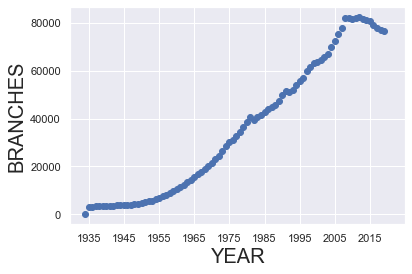

In [13]:
plt.scatter(x,y)
plt.xlabel(variables[0], fontsize=20)
plt.ylabel(variables[1], fontsize=20)
ticks = [x for x in range(1, 96, 10)]
plt.xticks(ticks)
plt.show()

nan


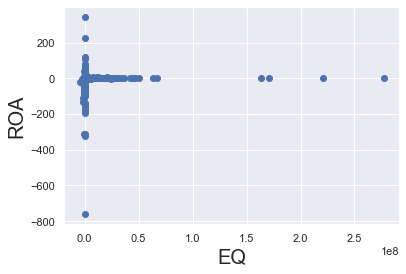

In [19]:
variables = ['EQ','ROA']
x = data[variables[0]]
y = data[variables[1]]

plt.scatter(x,y)
plt.xlabel(variables[0], fontsize=20)
plt.ylabel(variables[1], fontsize=20)
plt.show()

In [21]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np

In [22]:
targets = [0 if x < 1 else 1 for x in data_dropna['ROA']]
data_dropcols = data_dropna.drop(numeric_cols , axis=1)
data_dropcols['ROAb'] = targets

In [23]:
data_dropcols_shuff = data_dropcols.sample(frac=1, random_state=40)

In [24]:
num_one_targets = sum(targets)
zero_targets_counter = 0
indices = []

count = 0
for index,row in data_dropcols_shuff.iterrows():
    if (row['ROAb'] == 0):
        zero_targets_counter += 1
        if zero_targets_counter > num_one_targets:
            indices.append(index)

data_balanced = data_dropcols_shuff.drop(indices)

In [25]:
data_balanced_shuff = data_balanced.sample(frac=1, random_state=42)

In [26]:
targets = data_balanced_shuff['ROAb']
inputs = data_balanced_shuff.drop('ROAb', axis = 1)

inputs_scaled = preprocessing.scale(inputs)
train, test = train_test_split(inputs, test_size=0.10, random_state=42, shuffle=False)

train_targets = targets[:len(train)]
test_targets = targets[len(train):]

In [27]:
dtrain = xgb.DMatrix(train, label=train_targets)
dtest = xgb.DMatrix(test, label=test_targets)

In [28]:
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)

[14:36:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
# make prediction
preds = bst.predict(dtest)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

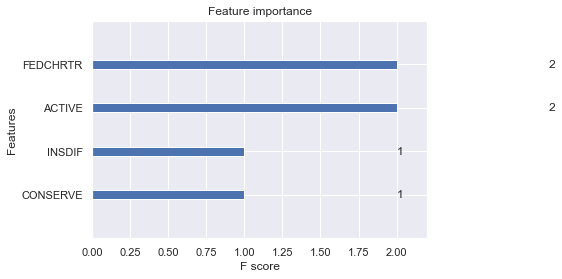

In [30]:
xgb.plot_importance(bst)

In [31]:
print(preds)

[0.51472896 0.34982654 0.42514995 ... 0.12499334 0.42514995 0.51472896]


In [32]:
count = 0

for i in range(len(test)):
    if preds[i] >= .5:
        pred = 1
    else:
        pred = 0
    if pred == test_targets.iloc[i]:
        count+=1
print(count/len(test))

0.6198439241917503


In [35]:
roa = data_dropna['ROA']

In [37]:
sum(roa) / len(roa)

-0.6908328070397003